-------------------------------------------------------
- Wiley Winters
- MSDS 686 Deep Learning
- Week 7-8 Kaggle Project&nbsp;&mdash;&nbsp;Brain Tumor Classification
- 2025-MAR-
--------------------------------------------------------

## Requirements

----------------------------------------------
### Required for 80%
Complete project on *kaggle.com* using the skills learned in the <u>Deep Learning</u> class.  The following are required:
- Show/plot sample images or data with labels
- Include at least on of the following
  - Convolution
  - Max Pooling
  - Batch Normalization
  - Dropout
  - LSTM
  - TF-IDf
- Use validation data
- Evaluate model on test data

-------------------------------------------
### Additional for another 20%
- Use data augmentation
- Use at least one of the following:
  - Kernels
  - Activation functions
  - Loss functions
  - Libraries
  - Methods
- Learning rate optimization
- Functional API model
- Transfer learning with or without trainable parameters
- Confusion matrix and / or ROC plots
- Plots of accuracy/loss vs epochs
- Show/plot sample incorrect prediction with labels and correct label

----------------------------------------------------------------
<a name='imports'></a>

## 1.0 <span style='color:blue'>|</span> Load Libraries and  Packages

In [1]:
# General Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, logging, random

# Data prep and model scoring
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, f1_score

# TensorFlow likes to display a lot of debug information
# on my home system
# I will squash the messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorFlow').setLevel(logging.FATAL)

# tensorflow and keras' API
import tensorflow as tf
from tensorflow import keras

# Model building
from keras.applications import Xception
from tensorflow.keras import backend, optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model architecture visualization
from visualkeras import layered_view

# Model training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

# Make plots have guidelines
plt.style.use('ggplot')
#%matplotlib inline

# Squash Python warnings
import warnings
warnings.filterwarnings('ignore')

E0000 00:00:1740838314.408798  612902 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740838314.414371  612902 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a name='configure'></a>

## 2.0 <span style='color:blue'>|</span> Configure Environment

<a name='seed'></a>

### 2.1 <span style='color:blue'>|</span> Set Random Seed for Reproducibility

In [2]:
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

<a name='global'></a>

### 2.2 <span style='color:blue'>|</span> Declare Global Variables

In [3]:
# Define training and testing image directories
home_dir = '/home/wiley'
trn_dir = home_dir+'/regis/dataScience/kaggleProject/images/data/training'
tst_dir = home_dir+'/regis/dataScience/kaggleProject/images/data/testing'

#home_dir = '/disk01/e384698'
#trn_dir = home_dir+'/msds686/week7/images/data/training/'
#tst_dir = home_dir+'/msds686/week7/images/data/testing/'

# Define classes
classes = ['negative', 'positive']

# Define early_stop callback
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-9, patience=8,
                           restore_best_weights=True)

# Define reduce LR on Plateau callback
reduceLRO = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5,
                              min_delta=0.0001, min_lr=0,
                              restore_best_weights=True)

# Image size and shape
img_size = (224, 224)
img_shape = (224, 224, 3)

# Number of classes
num_classes = 2

<a name='functions'></a>
## 3.0 <span style='color:blue'>|</span> Define Functions

------------------------------------------------------------------
<a name='dataframes'></a>
### 3.1 <span style='color:blue'>|</span> Load DataFrames
- Join image filename and path information
- Create labels from class directory names
- Create dataframe
- Randomize dataframe rows

In [4]:
def load_dataframe(path):
    labels, paths = zip(*[(label, os.path.join(path, label, image))
                        for label in os.listdir(path)
                        if os.path.isdir(os.path.join(path, label))
                        for image in os.listdir(os.path.join(path, label))])

    df = pd.DataFrame({'paths': paths, 'labels': labels})
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df

<a name='imports'></a>
### 3.2 <span style='color:blue'>|</span> Plot Performance Metrics
Plot the following:
- Training loss
- Validation loss
- Training Precision
- Validation Precision
- Training Recall
- Validation Recall

In [5]:
def plot_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.figure(figsize=(20,12))

    # Plot training and validation loss
    plt.subplot(2,2,1)
    plt.plot(epochs, history.history['loss'], 'b', label = 'Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(2,2,2)
    plt.plot(epochs, history.history['accuracy'], 'b', label = 'Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation AUPRC
    plt.subplot(2,2,3)
    plt.plot(epochs, history.history['auprc'], 'b', label='Training AUPRC')
    plt.plot(epochs, history.history['val_auprc'], 'r', label='Validation AUPRC')
    plt.title('Training and Validation AUPRC')
    plt.xlabel('Epochs')
    plt.ylabel('AUPRC')
    plt.legend()

    plt.suptitle('Model Training Metrics over Epochs', fontsize=16)
    plt.show()

<a name='evaluate'></a>
### 3.3 <span style='color:blue'>|</span> Evaluate Model's Performance
- Compute accuracy score
- Compute F1 score
- Compute ROC AUC Scores
- Create confusion matrix

In [6]:
def score_model(model, ds):
    my_model = model
    prediction = my_model.predict(ds)
    tr_labels = ds.classes
    pr_labels = prediction.argmax(axis=1)
    accur_score = accuracy_score(tr_labels, prediction)
    f1 = f1_score(tr_labels, prediction)
    roc_score = roc_auc_score(tr_labels, prediction)
    cm = confusion_matrix(tr_labels, pr_labels).flatten()
    
    print(f'Model:          {my_model}')
    print(f'Accuracy Score: {accur_score:.4f}')
    print(f'F1 score:       {f1:.4f}')
    print(f'ROC AUC Score:  {roc_score:.4f}')
    print(f'Confusion:\n    {cm}')
    
    return prediction

<a name='load_data'></a>
## 4.0 <span style='color:blue'>|</span> Load Data

---------------------------------------------------------------
<a name='load_df'></a>
### 4.1 <span style='color:blue'>|</span> Create and Load DataFrames

In [7]:
# Load training data
trn_df = load_dataframe(trn_dir)

# Load testing data
tst_df = load_dataframe(tst_dir)

# Take a look at the results
print('Training:   \n', trn_df.head(10).to_markdown())
print('Testing:    \n', tst_df.head(10).to_markdown())

Training:   
 |    | paths                                                                                            | labels   |
|---:|:-------------------------------------------------------------------------------------------------|:---------|
|  0 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/negative/Not Cancer  (1356).jpg | negative |
|  1 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/positive/Cancer (1321).jpg      | positive |
|  2 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/positive/Cancer (901).jpg       | positive |
|  3 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/positive/Cancer (15).tif        | positive |
|  4 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/positive/Cancer (968).jpg       | positive |
|  5 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/positive/Cancer (695).jpg       | positive |
|  6 | /home/wiley/regis/dataScience/kaggleProject

<a name='eda'></a>
## 5.0 <span style='color:blue'>|</span> EDA

-------------------------------------------------------
<a name='trn_dist'></a>
### 5.1 <span style='color:blue'>|</span> Look at Training Images' Distribution

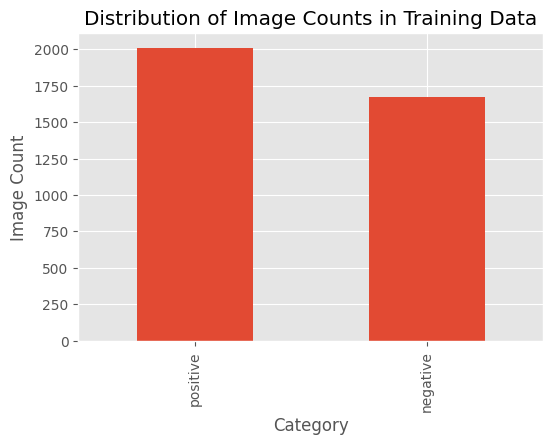

In [8]:
plt.figure(figsize=(6,4))
trn_df['labels'].value_counts().plot(kind='bar')
plt.title('Distribution of Image Counts in Training Data')
plt.xlabel('Category')
plt.ylabel('Image Count')
plt.show()

There are slightly more positive images than negative; however, the amount does not appear to be too significant.

<a name='tst_dist'></a>
### 5.2 <span style='color:blue'>|</span> Look at Testing Images' Distribution

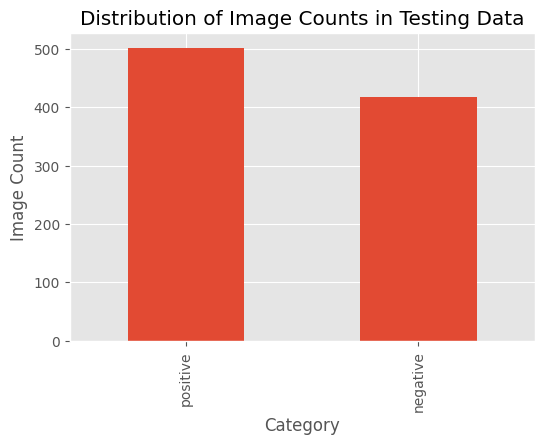

In [9]:
plt.figure(figsize=(6,4))
tst_df['labels'].value_counts().plot(kind='bar')
plt.title('Distribution of Image Counts in Testing Data')
plt.xlabel('Category')
plt.ylabel('Image Count')
plt.show()

Distribution mirrors what the *training data* shows, but with less frequency.

<a name='data_shape'></a>
### 5.3 <span style='color:blue'>|</span> Examine Shape of Training and Testing DataFrames

In [10]:
print('Training Shape: \n', trn_df.shape)
print('Testing Shape:  \n', tst_df.shape)

Training Shape: 
 (3681, 2)
Testing Shape:  
 (919, 2)


**NOTE:**&nbsp;&nbsp;Since the dataframes are built from the contents of the image directories, there should be no missing values or duplicates.

<a name='wrangling'></a>
## 6.0 <span style='color:blue'>|</span> Data Wrangling

---------------------------------------------------
<a name='trn_val_split'></a>
### 6.1 <span style='color:blue'>|</span> Create a Validation Subset from Training Data
I will use `flow_from_dataframe()` to create datasets for model training; therefore, no reason to create a new directory structure for validation data

In [11]:
val_df, trn_df = train_test_split(trn_df, train_size=0.2, random_state=42,
                                  stratify=trn_df['labels'])
val_df.sample(10)

,paths,labels
3586,/home/wiley/regis/dataScience/kaggleProject/im...,negative
514,/home/wiley/regis/dataScience/kaggleProject/im...,negative
2905,/home/wiley/regis/dataScience/kaggleProject/im...,negative
1956,/home/wiley/regis/dataScience/kaggleProject/im...,negative
577,/home/wiley/regis/dataScience/kaggleProject/im...,positive
3326,/home/wiley/regis/dataScience/kaggleProject/im...,positive
3082,/home/wiley/regis/dataScience/kaggleProject/im...,positive
2954,/home/wiley/regis/dataScience/kaggleProject/im...,positive
1196,/home/wiley/regis/dataScience/kaggleProject/im...,negative
2885,/home/wiley/regis/dataScience/kaggleProject/im...,positive


<a name='proc_imgs'></a>
### 6.2 <span style='color:blue'>|</span> Process Images from DataFrames
The `ImageDataGenerator()` method will be used for image augmentation even though it is depreciated according to this [site](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).  It also appears that `flow_from_dataframe()` is also depreciated.

In [12]:
bs = 32

gen = ImageDataGenerator(rescale=1./255,
                         brightness_range=(0.5, 1.5),
                         rotation_range=20,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.2,
                         zoom_range=0.2)

tst_gen = ImageDataGenerator(rescale=1./255)

trn_gen = gen.flow_from_dataframe(trn_df, x_col='paths', y_col='labels',
                                  batch_size=bs, target_size=img_size,
                                  shuffle=True)

val_gen = gen.flow_from_dataframe(val_df, x_col='paths', y_col='labels',
                                  batch_size=bs, target_size=img_size,
                                  shuffle=True)

tst_gen = tst_gen.flow_from_dataframe(tst_df, x_col='paths', y_col='labels',
                                      batch_size=16, target_size=img_size,
                                      shuffle=False)

Found 2945 validated image filenames belonging to 2 classes.
Found 736 validated image filenames belonging to 2 classes.
Found 919 validated image filenames belonging to 2 classes.


<a name='proc_imgs'></a>
### 6.3 <span style='color:blue'>|</span> Examine a few Images and their Labels
These images have been processed and augmentation applied.

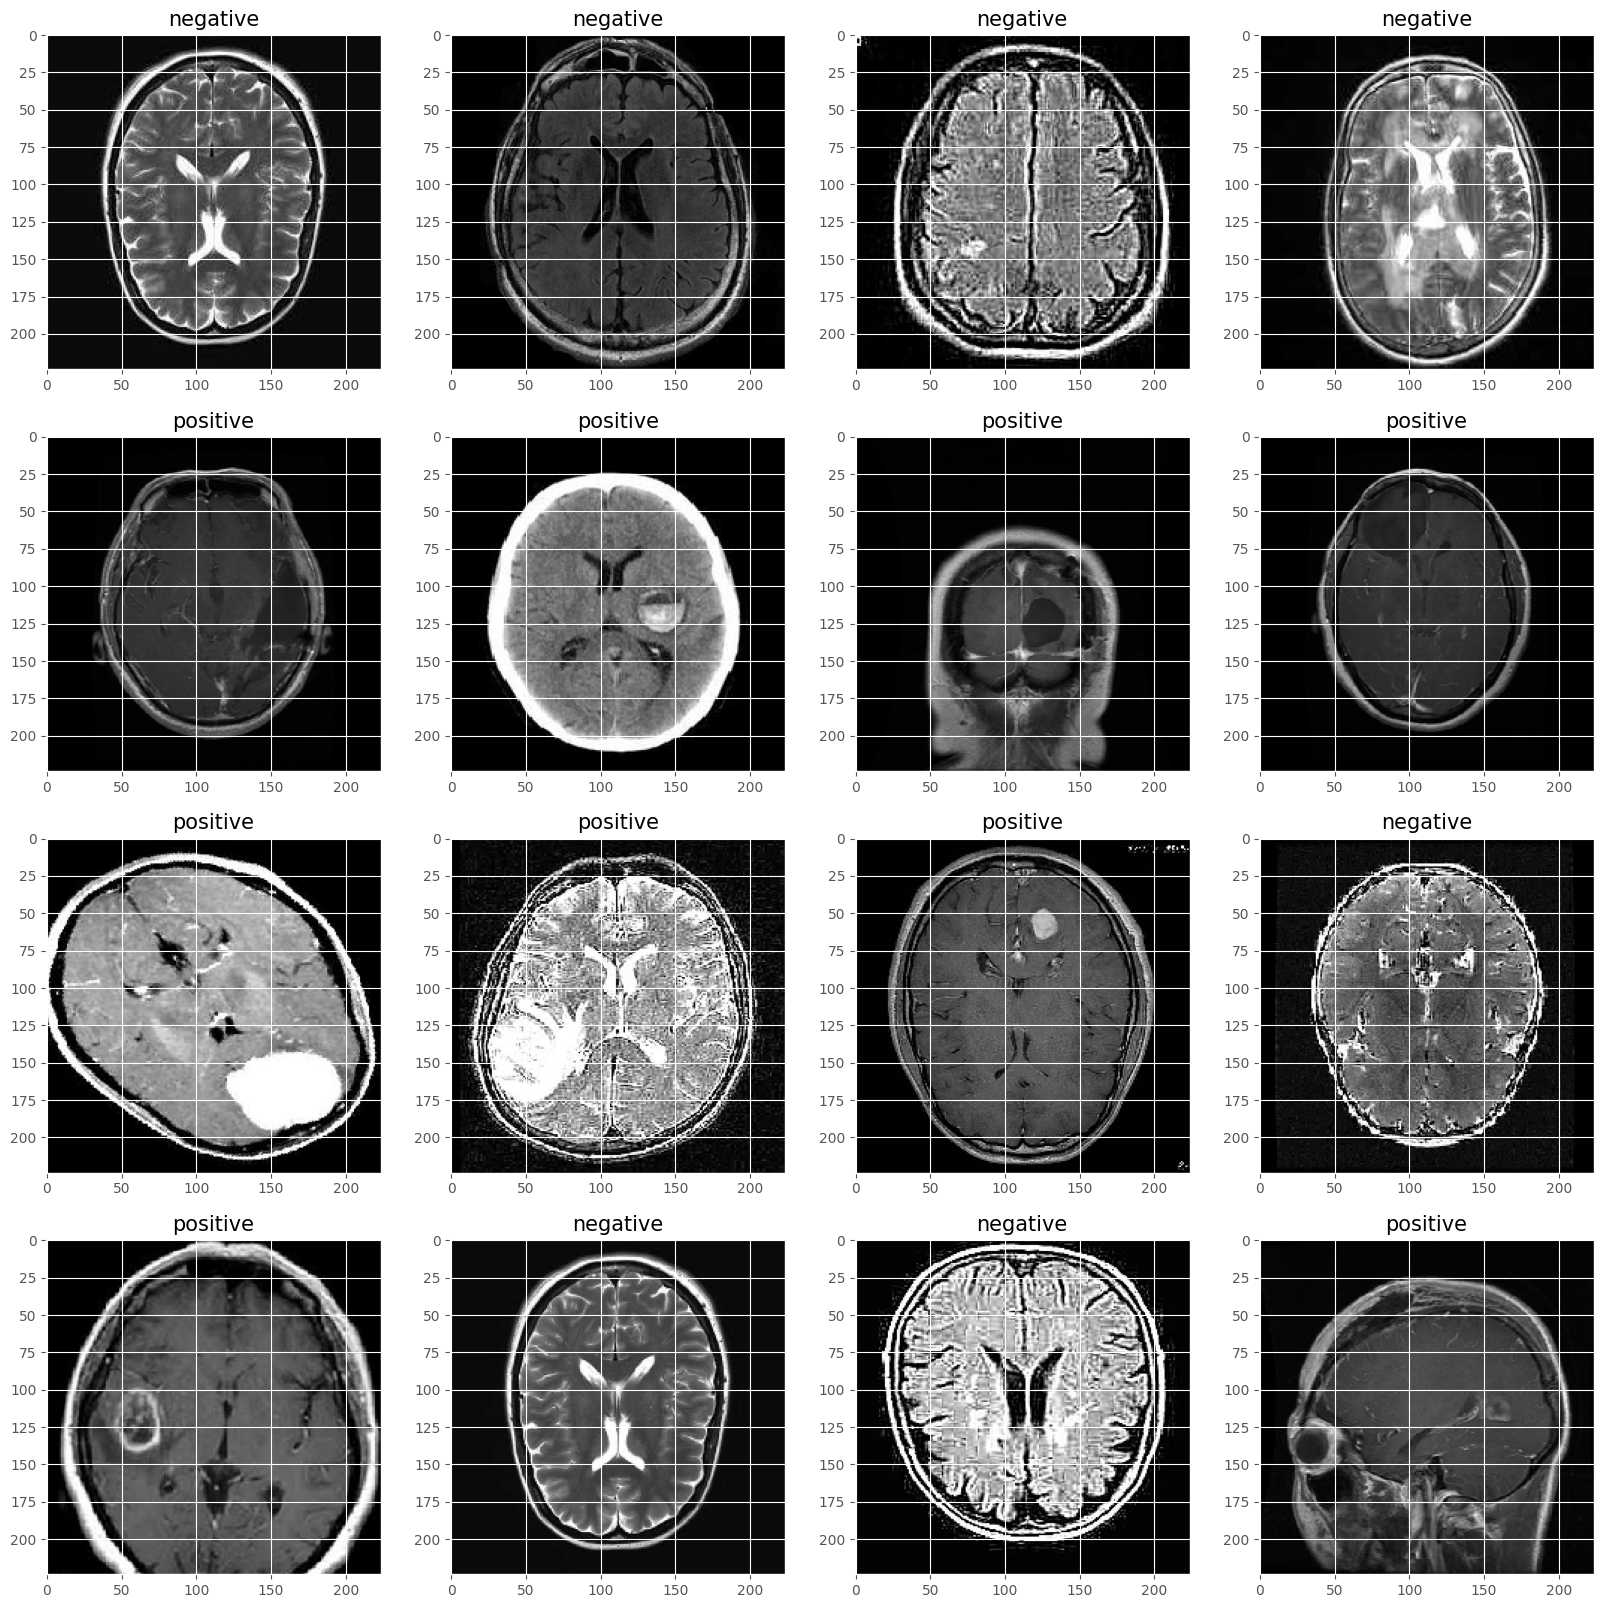

In [13]:
dict = trn_gen.class_indices
classes = list(dict.keys())
images, labels = next(tst_gen)

plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4,i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

<a name='config_model'></a>
## 7.0 <span style='color:blue'>|</span> Configure Training Environment

---------------------------------------------------------------------------------------
<a name='trn_vars'></a>
### 7.1 <span style='color:blue'>|</span> Set Model Training Variables

In [14]:
# Initial batch size
batch_size = 64

# Number of training epochs
epochs = 75

# Steps per epoch
steps_per_ep = trn_gen.samples // batch_size

# Validation steps
val_steps = tst_gen.samples // batch_size

print(f'Image shape:      {img_shape}')
print(f'Epochs:           {epochs}')
print(f'Batch size:       {batch_size}')
print(f'Steps per epoch:  {steps_per_ep}')
print(f'Validation steps: {val_steps}')

Image shape:      (224, 224, 3)
Epochs:           75
Batch size:       64
Steps per epoch:  46
Validation steps: 14


<a name='model_arch'></a>
### 7.2 <span style='color:blue'>|</span> Define Model's Architecture

In [15]:
# Input Layer
inputs  = Input(shape=(img_shape))

# Conv Layer 1
conv1   = Conv2D(filters=64, kernel_size=4, padding='same',
                 activation='relu')(inputs)
pool1   = MaxPooling2D(pool_size=(3,3))(conv1)

# Conv Layer 2
conv2   = Conv2D(filters=64, kernel_size=4, padding='same',
                 activation='relu')(pool1)
pool2   = MaxPooling2D(pool_size=(3,3))(conv2)

# Conv Layer 3
conv3   = Conv2D(filters=128, kernel_size=4, padding='same',
                 activation='relu')(pool2)
pool3   = MaxPooling2D(pool_size=(2,2))(conv3)

# Conv Layer 4
conv4   = Conv2D(filters=128, kernel_size=4, padding='same',
                 activation='relu')(pool3)
pool4   = MaxPooling2D(pool_size=(2,2))(conv4)

# Conv Layer 5
#conv5   = Conv2D(filters=512, kernel_size=4, padding='same',
#                 activation='relu')(pool4)
#pool5   = MaxPooling2D(pool_size=(2,2))(conv5)

# Apply Batch Normalization, Flatten, and Dense Layers
batch3  = BatchNormalization()(pool4)
flatten = Flatten()(batch3)
dense1   = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.5, seed=42)(dense1)
dense2   = Dense(512, activation='relu')(dropout)

# Pull the model together
preds   = Dense(num_classes, activation='softmax')(dense1)

model_base = Model(inputs, preds)

model_base.summary()

I0000 00:00:1740838545.555391  612902 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9617 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:09:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,052,930 (4.02 MB)

 Trainable params: 1,052,674 (4.02 MB)

 Non-trainable params: 256 (1.00 KB)

<a name='visualkeras'></a>
### 7.3 <span style='color:blue'>|</span> Visualize Layers

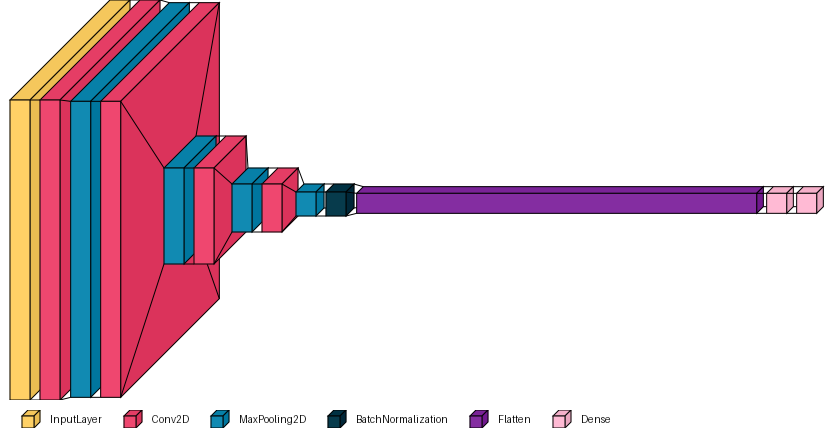

In [16]:
layered_view(model_base, legend=True, max_xy=300)

<a name='bld_model'></a>
## 8.0 <span style='color:blue'>|</span> Build and Train

------------------------------------------------------------
<a name='compile'></a>
### 8.1 <span style='color:blue'>|</span> Compile and Train Model

In [17]:
# Reset environment
backend.clear_session()

# Compile base model
opt = optimizers.Adam(learning_rate=0.0005)
model_base.compile(optimizer=opt, loss='categorical_crossentropy',
                   metrics=['accuracy', 
                            tf.keras.metrics.AUC(curve='PR', name='auprc')])

hist_base = model_base.fit(trn_gen, steps_per_epoch=steps_per_ep, epochs=epochs,
                           validation_data=val_gen,
                           validation_steps=val_steps,
                           callbacks=[early_stop, reduceLRO])

Epoch 1/75


I0000 00:00:1740838572.276023  613272 service.cc:148] XLA service 0x7fadf000f3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740838572.276049  613272 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
I0000 00:00:1740838572.580363  613272 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/46 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4688 - auprc: 0.5016 - loss: 0.9457

I0000 00:00:1740838576.668140  613272 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/46 ━━━━━━━━━━━━━━━━━━━━ 28s 477ms/step - accuracy: 0.5289 - auprc: 0.5437 - loss: 0.8277 - val_accuracy: 0.5781 - val_auprc: 0.5778 - val_loss: 0.6916 - learning_rate: 5.0000e-04
Epoch 2/75
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 316ms/step - accuracy: 0.6348 - auprc: 0.6562 - loss: 0.6500 - val_accuracy: 0.6910 - val_auprc: 0.7065 - val_loss: 0.6842 - learning_rate: 5.0000e-04
Epoch 3/75
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.6250 - auprc: 0.6386 - loss: 0.6637 - val_accuracy: 0.5848 - val_auprc: 0.6543 - val_loss: 0.6847 - learning_rate: 5.0000e-04
Epoch 4/75
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 329ms/step - accuracy: 0.6492 - auprc: 0.6799 - loss: 0.6348 - val_accuracy: 0.6840 - val_auprc: 0.7290 - val_loss: 0.6755 - learning_rate: 5.0000e-04
Epoch 5/75
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 359ms/step - accuracy: 0.6883 - auprc: 0.7375 - loss: 0.5992 - val_accuracy: 0.6295 - val_auprc: 0.7018 - val_loss: 0.6741 - learning_rate: 5.0000e-04
Epoch 6/75
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/st

InvalidArgumentError: {{function_node __wrapped__Mean_device_/job:localhost/replica:0/task:0/device:GPU:0}} Invalid reduction dimension (0 for input with 0 dimension(s) [Op:Mean] name: 

<a name='history'></a>
### 8.2 <span style='color:blue'>|</span> Plot Training / Validation Performance

In [ ]:
plot_history(hist_base)

<a name='evaluate_tst'></a>
### 8.3 <span style='color:blue'>|</span> Evaluate Test Data Performance

In [ ]:
loss, acc, auprc = model_base.evaluate(tst_gen)
print(f'Test Loss:     {loss:.4f}')
print(f'Test Accuracy: {acc:.4f}')
print(f'Test AUPRC:    {auprc:.4f}')

In [ ]:
hist = pd.DataFrame(hist_base.history)
hist.tail()

In [ ]:
pred = model_base.predict(tst_gen)
tr_lab = tst_gen.classes
pr_lab = pred.argmax(axis=1)

cm = confusion_matrix(tr_lab, pr_lab)
cm